In [1]:
# Decide whether or not running on Kaggle
import os
KAGGLE_RUN = True
N_TRAIN_ROWS = 40 * 1000000
if os.path.isdir('/home/ubuntu'):
    KAGGLE_RUN = False
    
if KAGGLE_RUN:
    model_name = 'model5/model5.txt'
else:
    model_name = 'model5.txt'
    
# Libraries
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score

from collections import defaultdict
import lightgbm as lgb
import random
if not KAGGLE_RUN:
    import sys
    sys.path.insert(0, './input')
    import local_work
import riiideducation

# Boto3 Setup and Download Files
if not KAGGLE_RUN:
    local_work = local_work.local_work()
    local_work.download_riiid_files()
    
# Column definitions    
train_cols = ['user_id', 'timestamp', 'task_container_id'
              ,'content_id', 'content_type_id', 'answered_correctly'
             ,'prior_question_elapsed_time', 'prior_question_had_explanation']
target = 'answered_correctly'

In [2]:
# Load data
if not KAGGLE_RUN:
    df_train = local_work.get_train_data(train_cols, nrow=N_TRAIN_ROWS)
    df_questions = local_work.get_questions_data()
else:
    import datatable as dt
    df_train = dt.fread('../input/riiid-test-answer-prediction/train.csv'
                        ,columns=set(train_cols)
                        ,max_nrows=N_TRAIN_ROWS).to_pandas()
    df_questions = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv'
                                ,usecols=[0, 3]
                                ,dtype={'question_id': 'int16', 'part': 'int8'}
                               )
    

# Cleaning function
def clean(df, target, df_questions, is_train):
    # Only keep question rows
    df = df[df['content_type_id'] == 0].reset_index(drop=True)
    
    # Assume False if NA (Only for first question ? )
    df['prior_question_had_explanation'].fillna(False, inplace=True)  
    
    # Alter columns types
    tmp = {'user_id': 'int32'
            ,'content_id': 'int16'
            ,target: 'int8'
            ,'prior_question_elapsed_time': 'float32' 
            ,'prior_question_had_explanation': 'bool'
            }
    if not is_train:
        del tmp[target]
    df = df.astype(tmp)
    
    # Merge questions
    df = pd.merge(df, df_questions, left_on='content_id', right_on='question_id', how='left')
        
    return(df)

# Feature Engineering function
def do_fe(df
          ,is_train
          ,content_agg=None
          ,user_sum_dict=None
          ,user_count_dict=None
          ,content_sum_dict=None
          ,content_count_dict=None
          ,user_prev_task_sum_dict=None
          ,user_prev_task_count_dict=None
         ):

    if is_train:
        # - # - # Attach information about the previous task(s) # - # - #

        # Get sum/count of answers in current, previous, and cumulative tasks.
        df_tasks = df\
                    .groupby(['user_id', 'task_container_id'])[target]\
                    .agg(['sum', 'count'])\
                    .rename(columns={'sum': 'task_sum', 'count': 'task_count'})
        df_tasks['prev_task_sum'] = df_tasks.groupby('user_id')['task_sum'].shift()
        df_tasks['prev_task_count'] = df_tasks.groupby('user_id')['task_count'].shift()
        df_tasks['prev_task_cum_sum'] = df_tasks.groupby('user_id')['prev_task_sum'].cumsum()
        df_tasks['prev_task_cum_count'] = df_tasks.groupby('user_id')['prev_task_count'].cumsum()

        # FE accuracy on previous task(s)
        df_tasks['prev_task_correctness'] = df_tasks['prev_task_sum']/df_tasks['prev_task_count']
        df_tasks['prev_task_cum_correctness'] = df_tasks['prev_task_cum_sum']/\
                                                    df_tasks['prev_task_cum_count']

        # Drop undesired columns
        df_tasks.drop(columns=['prev_task_sum', 'prev_task_count', 'prev_task_cum_sum'], inplace=True)

        # Join to df_tasks to df_train
        df = df.merge(df_tasks, on=['user_id', 'task_container_id'])
        
        # Garbage College
        del df_tasks
        gc.collect()
    
    else:
        # Initialize user/content sums
        user_sum = np.zeros(len(df), dtype=np.int16)
        user_count = np.zeros(len(df), dtype=np.int16)
        user_prev_sum = np.zeros(len(df), dtype=np.int16)
        user_prev_count = np.zeros(len(df), dtype=np.int16)

        # Get user/content sums
        for i, user_id in enumerate(df['user_id'].values):
            user_sum[i] = user_sum_dict[user_id]
            user_count[i] = user_count_dict[user_id]
            user_prev_sum[i] = user_prev_task_sum_dict[user_id]
            user_prev_count[i] = user_prev_task_count_dict[user_id]
        with np.errstate(divide='ignore', invalid='ignore'):
            df['prev_task_cum_correctness'] = user_sum / user_count
            df['prev_task_correctness'] = user_prev_sum / user_prev_count
        df['prev_task_cum_count'] = user_count
        
    # Content Columns - Not updating throughout testing phase
    df['content_count'] = df['content_id'].map(content_agg['count']).astype('int32')
    df['content_avg_correctness'] = df['content_id'].map(content_agg['sum'] / content_agg['count'])
    
    return(df)

In [3]:
# Capture content information
content_agg = df_train.groupby('content_id')[target].agg(['sum', 'count'])

# Clean
df_train = clean(df_train
                 ,target
                 ,df_questions
                 ,is_train=True
                )

# Feature Engineer
df_train = do_fe(df_train, is_train=True, content_agg = content_agg)

# - # - # Capture Info for Test Set Before Train/Val Split # - # - #
# Capture user aggregate (cumlative) information
user_agg = df_train.groupby('user_id')[target].agg(['sum', 'count'])

# Capture information on most recent task
user_prev_task = df_train.groupby('user_id')\
                    .tail(1)[['user_id', 'task_sum', 'task_count']]\
                    .rename(columns={'task_sum' : 'prev_task_sum', 'task_count' : 'prev_task_count'})\
                    .set_index('user_id')

# Delete uneeded columns
df_train.drop(columns=['task_sum'
                       ,'task_count'
                       ,'question_id'
                       ,'content_id'
                       ,'task_container_id'
                       ,'content_type_id'
                      ]
              ,inplace=True)

Model

[LightGBM] [Info] Number of positive: 23944104, number of negative: 12351198
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.284384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4760
[LightGBM] [Info] Number of data points in the train set: 36295302, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.659703 -> initscore=0.661969
[LightGBM] [Info] Start training from score 0.661969
Training until validation scores don't improve for 20 rounds
[50]	training's auc: 0.752196	valid_1's auc: 0.754753
[100]	training's auc: 0.75323	valid_1's auc: 0.75524
Early stopping, best iteration is:
[83]	training's auc: 0.752938	valid_1's auc: 0.755284


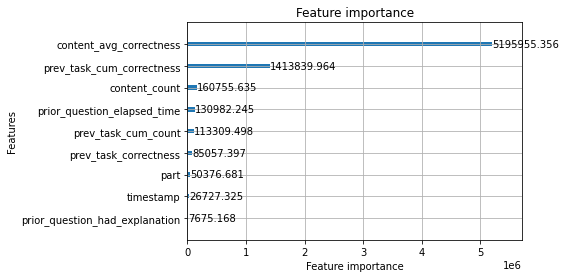

In [4]:
# Define features
features = [
            # Task related
            'prev_task_correctness'
            ,'prev_task_cum_count'
            ,'prev_task_cum_correctness'
            #,'task_count'
            # Content related
            ,'content_avg_correctness'
            ,'content_count'
            # From df_train
            ,'timestamp'
            ,'prior_question_elapsed_time'
            ,'prior_question_had_explanation'
            # From df_questions
            ,'part'
            ]

assert(len(features) == (df_train.shape[1] - 2)) # Minuse 2 for target and user_id
    
if not KAGGLE_RUN:    
    
    # - # - # Make Validation Set # - # - #
    
    # Add entire user histories to validation set
    tmp = df_train.user_id.unique()
    val_full_ids = np.random.choice(tmp, int(.05 * tmp.shape[0]))
    df_valid_full = df_train.loc[df_train['user_id'].isin(val_full_ids)]
    df_train.drop(df_valid_full.index, inplace=True)

    # Add start of user histories to validation set
    tmp = df_train.user_id.unique()
    val_start_ids = np.random.choice(tmp, int(.07 * tmp.shape[0]))
    df_valid_start = df_train.loc[df_train['user_id'].isin(val_start_ids)].groupby('user_id').head(100)
    df_train.drop(df_valid_start.index, inplace=True)

    # Add ending of user histories to validation set
    tmp = df_train.user_id.unique()
    val_end_ids = np.random.choice(tmp, int(.07 * tmp.shape[0]))
    df_valid_end = df_train.loc[df_train['user_id'].isin(val_end_ids)].groupby('user_id').head(100)
    df_train.drop(df_valid_end.index, inplace=True)
    
    # Combine the sets
    df_valid = df_valid_full.append([df_valid_start, df_valid_end])
    
    # - # - # Build and Save Model # - # - #
    if True:
        model = local_work.make_model(df_train, df_valid, target, features, learning_rate=.8)
        model.save_model(f'./output/' + model_name)
        lgb.plot_importance(model, importance_type='gain')
    else:
        model = lgb.Booster(model_file='./output/' + model_name)
        lgb.plot_importance(model, importance_type='gain')
    
else:
    model = lgb.Booster(model_file='/kaggle/input/' + model_name)

In [5]:
# Setup dicts
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
user_prev_task_sum_dict = user_prev_task['prev_task_sum']\
                            .astype('int16').to_dict(defaultdict(int))
user_prev_task_count_dict = user_prev_task['prev_task_count']\
                            .astype('int16').to_dict(defaultdict(int))

# Make env
env = riiideducation.make_env()
iter_test = env.iter_test()
df_prior_test = None

# Make predictions
for (df_test, df_sample_prediction) in iter_test:
    
    if df_prior_test is not None:
        # Attach whether or not users answered correctly
        df_prior_test[target] = eval(df_test['prior_group_answers_correct'].iloc[0])
        df_prior_test = df_prior_test[df_prior_test[target] != -1].reset_index(drop=True)

        user_ids = df_prior_test['user_id'].values
        content_ids = df_prior_test['content_id'].values
        targets = df_prior_test[target].values
        
        # If user present in current batch, reset the previous task dictionary
        for user_id in df_test['user_id'].unique():
            user_prev_task_sum_dict[user_id] = 0
            user_prev_task_count_dict[user_id] = 0

        # Update user and content dictionaries
        for user_id, content_id, answered_correctly in zip(df_prior_test['user_id'].values
                                                           ,df_prior_test['content_id'].values
                                                           ,df_prior_test[target].values):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            user_prev_task_sum_dict[user_id] += answered_correctly
            user_prev_task_count_dict[user_id] += 1

    # Make a copy of df_test for the next iteration
    df_prior_test = df_test.copy()
 
    # Clean
    df_test = clean(df_test
                     ,target
                     ,df_questions
                     ,is_train=False
                    )
    
    # Feature engineer
    df_test = do_fe(df_test
                    ,is_train=False
                    ,content_agg = content_agg
                    ,user_sum_dict = user_sum_dict
                    ,user_count_dict = user_count_dict
                    ,user_prev_task_sum_dict = user_prev_task_sum_dict
                    ,user_prev_task_count_dict = user_prev_task_count_dict
                    )
    
    # Make prediction
    df_test[target] = model.predict(df_test[features])
    env.predict(df_test[['row_id', target]])
    
print("Finished")

Finished


Explorations

In [ ]:
# Make env
import riiideducation
env = riiideducation.make_env()
iter_test = env.iter_test()

In [ ]:
all_dfs = []
for (df_test, df_sample_prediction) in iter_test:
    all_dfs.append(df_test)
    df_test[target] = .5
    env.predict(df_test[['row_id', target]])

In [ ]:
i = 1
for i in range(3):
    print(all_dfs[i].shape[0])
    print(len(all_dfs[i].user_id.unique()) - all_dfs[i].shape[0])